<a href="https://www.kaggle.com/code/mesutssmn/dog-breed-cnn-nasnetlarge?scriptVersionId=166344948" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

2024-03-10 17:12:16.177549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 17:12:16.177674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 17:12:16.308501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "/kaggle/input/dog-breed-identification/train"
test_dir = "/kaggle/input/dog-breed-identification/test"

In [3]:
train_img = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
test_img = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

In [4]:
df_train = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
df_train.head()
len(df_train.breed.unique())

120

In [5]:
df_train.rename(columns = {"breed": "label"}, inplace = True)
df_train["id"] = df_train["id"].apply(lambda x: x+"."+"jpg")
df_train.head()


,id,label
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [6]:
test_files = os.listdir(test_dir)
df_test = pd.DataFrame({"id": test_files, "label": "dingo"})
df_test.head()

,id,label
0,09e51e17e2b756ff2ace8a87bd1443fa.jpg,dingo
1,f7a32505c12649183c5991ecfa7d68b3.jpg,dingo
2,bc6d50ffb4644feb34530aa58943e85b.jpg,dingo
3,7cbc041e79135a572aad87904b5c9c57.jpg,dingo
4,f3b603f10d6a344f0395fb46b242ff8e.jpg,dingo


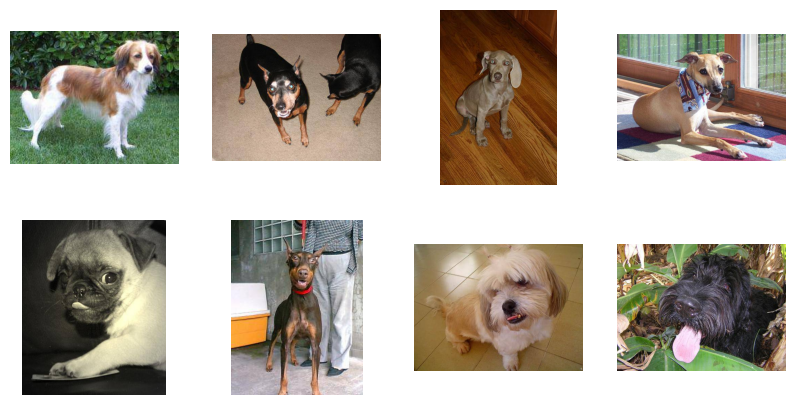

In [7]:
src_path = "../input/dog-breed-identification/train"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [8]:
train_size = len(df_train)
test_size = len(df_test)

train_size,test_size

(10222, 10357)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split = 0.2)

In [10]:
train_generator = train_datagen.flow_from_dataframe(df_train, train_dir,
    x_col = 'id',
    y_col = 'label',
    subset = 'training',
    color_mode = 'rgb',
    class_mode = 'categorical',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    seed = 1881)

Found 8178 validated image filenames belonging to 120 classes.


In [11]:
validation_generator = train_datagen.flow_from_dataframe(df_train, train_dir,
    x_col = 'id',
    y_col = 'label',
    subset = 'validation',
    color_mode = 'rgb',
    class_mode = 'categorical',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    seed = 1881)


Found 2044 validated image filenames belonging to 120 classes.


In [12]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=test_dir,
x_col="id",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224),
color_mode="rgb")

Found 10357 validated image filenames.


In [13]:
conv_model = tf.keras.applications.NASNetLarge(
                  weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)
               )
conv_model.trainable = False
conv_model.summary()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "NASNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │      2,592 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │      4,032 │ activation[0][0]  │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │      2,814 │ activation_2[0][

 Total params: 84,916,818 (323.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 84,916,818 (323.93 MB)

In [14]:
model = tf.keras.models.Sequential()

model.add(conv_model)

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['acc'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NASNet (Functional)             │ ?                      │    84,916,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,916,818 (323.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 84,916,818 (323.93 MB)

In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.001,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)]

In [16]:
history = model.fit(
    train_generator,
    epochs=50,
    callbacks=callbacks,
    validation_data=validation_generator,
    batch_size=40)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710090879.155469      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710090879.345821      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/256 ━━━━━━━━━━━━━━━━━━━━ 56:56 14s/step - acc: 0.0000e+00 - loss: 5.0579 

W0000 00:00:1710090906.463414      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - acc: 0.0156 - loss: 4.9902

W0000 00:00:1710091080.210805      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710091143.009389      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


256/256 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - acc: 0.0157 - loss: 4.9895 - val_acc: 0.1052 - val_loss: 4.2541
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 179s 615ms/step - acc: 0.0859 - loss: 4.2984 - val_acc: 0.4359 - val_loss: 3.6076
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 166s 633ms/step - acc: 0.2829 - loss: 3.6365 - val_acc: 0.6213 - val_loss: 3.0274
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 165s 630ms/step - acc: 0.4648 - loss: 3.0555 - val_acc: 0.6932 - val_loss: 2.5293
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 157s 599ms/step - acc: 0.5767 - loss: 2.5849 - val_acc: 0.7182 - val_loss: 2.1355
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 155s 592ms/step - acc: 0.6515 - loss: 2.2100 - val_acc: 0.7241 - val_loss: 1.8515
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 158s 602ms/step - acc: 0.6869 - loss: 1.9060 - val_acc: 0.7270 - val_loss: 1.6394
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 159s 606ms/step - acc: 0.7051 - loss: 1.6907 - val_acc: 0.7456 - val_loss: 1.4583
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━

In [17]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

/tmp/ipykernel_27/936689615.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


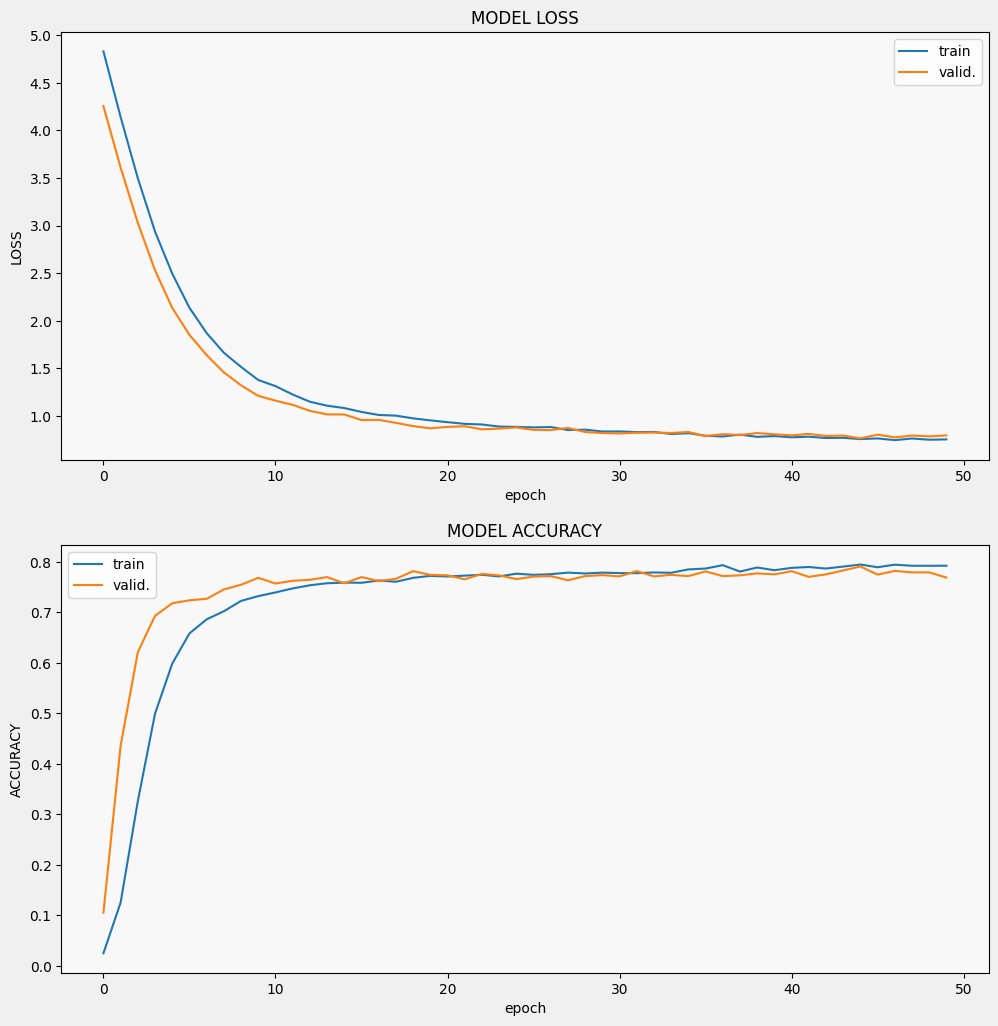

In [18]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'ACCURACY',
    212,
)

In [19]:
score = model.evaluate(validation_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - acc: 0.7779 - loss: 0.8357
Accuracy: 78.23%
Loss:  0.79423588514328


In [20]:
pred=model.predict(test_generator)

  1/324 ━━━━━━━━━━━━━━━━━━━━ 1:44:45 19s/step

W0000 00:00:1710099055.432249      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


324/324 ━━━━━━━━━━━━━━━━━━━━ 150s 404ms/step


W0000 00:00:1710099186.069504      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
df_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
df_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [22]:
df_submission.iloc[:,1:] = pred
df_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000198,0.000159,0.000170,0.000106,0.423775,0.000334,0.000393,0.000734,0.000078,...,0.000463,0.000367,0.000177,0.000281,0.000210,0.000041,0.000433,0.000411,0.000202,0.000191
1,00102ee9d8eb90812350685311fe5890,0.000029,0.000073,0.000043,0.000024,0.000285,0.000069,0.000050,0.000089,0.000589,...,0.000098,0.000061,0.001378,0.001299,0.000100,0.000121,0.000047,0.000144,0.000049,0.000048
2,0012a730dfa437f5f3613fb75efcd4ce,0.000028,0.000236,0.000050,0.000065,0.000109,0.000102,0.000049,0.000072,0.000058,...,0.000055,0.000034,0.000031,0.000052,0.000054,0.000103,0.000026,0.000033,0.000025,0.000029
3,001510bc8570bbeee98c8d80c8a95ec1,0.000103,0.000232,0.000280,0.000299,0.000604,0.000055,0.000134,0.000509,0.000152,...,0.000376,0.000305,0.000077,0.000081,0.012810,0.000092,0.000146,0.013352,0.000401,0.000441
4,001a5f3114548acdefa3d4da05474c2e,0.000016,0.000041,0.000057,0.000020,0.000058,0.000077,0.000070,0.000123,0.000343,...,0.000036,0.000036,0.000111,0.000049,0.000108,0.983545,0.000025,0.000089,0.000034,0.000053


In [23]:
final_df = df_submission.set_index('id')
final_df.to_csv('Submission.csv')